<a href="https://colab.research.google.com/github/Ao-Baid/steamrecommendation/blob/main/Steam_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary libraries for data visualisation, training and evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import csv

Loading the data

In [2]:
root_dir = 'data'

df_games = pd.read_csv(root_dir + '/games.csv')
df_games_meta = pd.read_json(root_dir + '/games_metadata.json', lines=True, orient="records")
df_recommendations = pd.read_csv(root_dir + '/recommendations.csv')
df_users = pd.read_csv(root_dir + '/users.csv')

pd.DataFrame([
    ["Recommendations", len(df_recommendations.index)],
    ["Users", len(df_users.index)],
    ["Games", len(df_games.index)],
    ["Games Metadata", len(df_games_meta.index)]
], columns=["Dataframe", "Records"])

,Dataframe,Records
0,Recommendations,41154794
1,Users,14306064
2,Games,50872
3,Games Metadata,50872


A clearer view of the games tables and the attributes it contains:


*   app_id (native product ID on steam)
*   title
*   date_release
*   OS support
*   Product rating type
*   Ratio of positive feedbacks
*   Number of reviews
*   Pricing (original and discounted)
*   Steam Deck compatibility




In [3]:
df_games.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


Users table contains the attributes:


*   user_id (Primary key)
*   Number of products purchased by the user
*   Number of reviews published on steam



In [4]:
df_users.head()

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2


Recommendations table contains the attributes:

* Primary key: review auto-generated ID
* Foreign key on Games table: native product ID on Steam
* Foreign key on Users table: user augo
* How many users found a recommendation helpful/funny
* Product recommended (not recommended) by user
* How many hours played by the user.

In [5]:
df_recommendations.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4


# Data Preparation

**Check for missing values**

In [7]:
def percentage_na(df: pd.DataFrame) -> float:
  """Calculates the percentage of missing values in the dataframe we created"""
  return np.count_nonzero(df.isnull().values) / (df.shape[0] * df.shape[1]) * 100

pd.DataFrame([
    ["Recommendations", percentage_na(df_recommendations)],
    ["Users", percentage_na(df_users)],
    ["Games", percentage_na(df_games)],
], columns=["Dataframe", "% of Missing Values"])


,Dataframe,% of Missing Values
0,Recommendations,0.0
1,Users,0.0
2,Games,0.0


# Distribution of game ratings
Using the games table, we can create a distribution to showcase the most common game ratings.

From this chart, games are usually rated more postively than negatively and the proportion of overwhelmingly positive games to overwhelmingly negative games is considerable

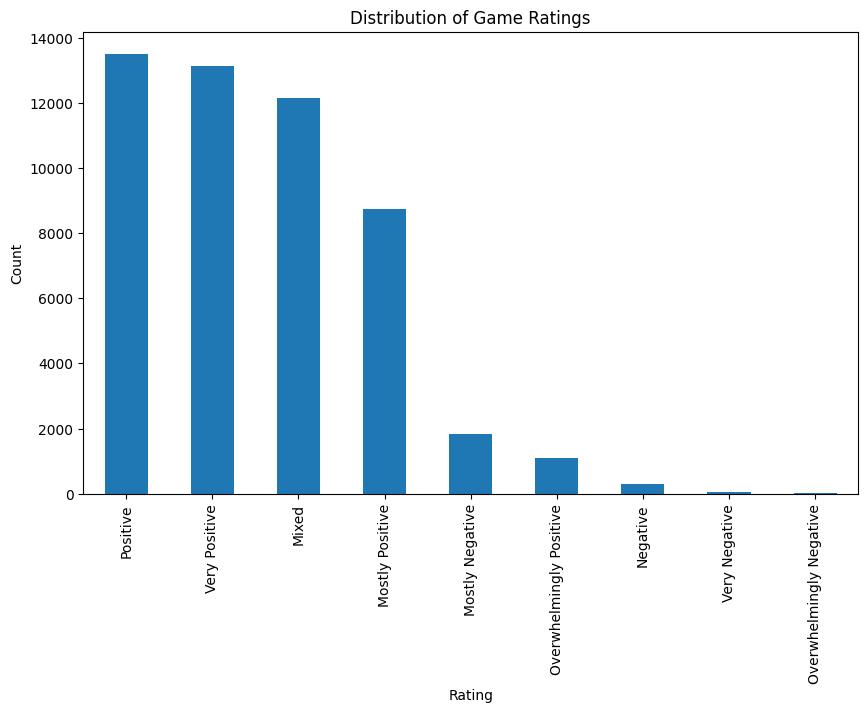

In [8]:
plt.figure(figsize=(10, 6))
df_games['rating'].value_counts().plot(kind='bar')
plt.title('Distribution of Game Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Most popular gaming categories

<Figure size 1200x800 with 0 Axes>

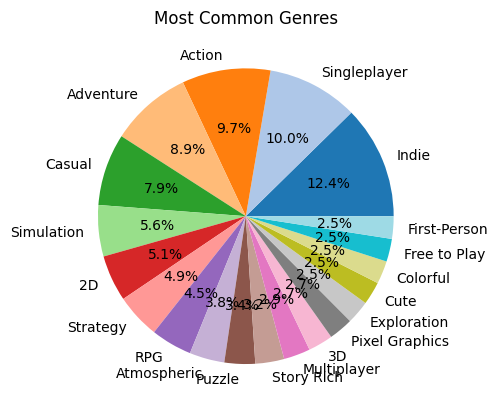

In [ ]:
from collections import Counter

# Extract genres from the tags column
genres = df_games_meta['tags'].explode()

# Count the occurrences of each genre
genre_counts = Counter(genres)

# Convert the counts to a DataFrame
df_genre_counts = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

# Sort the DataFrame by count in descending order
df_genre_counts = df_genre_counts.sort_values(by='Count', ascending=False)

# Plot the most common genres as a pie chart
plt.figure(figsize=(12, 8))
colors = plt.cm.tab20(np.linspace(0, 1, 20))
df_genre_counts.head(10).set_index('Genre').plot(kind='pie', y='Count', legend=False, autopct='%1.1f%%', colors=colors)
plt.title('Most Common Genres')
plt.ylabel('')
plt.show()
